In [101]:
import sqlite3
import numpy as np; import pandas as pd
import re; import datetime; from collections import Counter
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb

####################### 데이터 불러오고 정제하는 과정 #######################
#### 단, one-hot coding 하는 부분은 살필 것. - 차후 날씨 등 데이터 돌릴 때 one-hot 필수 ####

con = sqlite3.connect(r'C:\Users\myeon\Desktop\Data Science\project\db\race.db')
cursor = con.cursor()

cursor.execute("SELECT total_hn_bu.date, total_hn_bu.no, total_hn_bu.distance, total_hn_bu.horse_name, total_hn_bu.horse_no, \
                total_hn_bu.horse_weight, total_hn_bu.horse_weight_pm, total_hn_bu.location, total_hn_bu.race_time, \
                total_hn_bu.road_cd_pc, total_hn_bu.weather, total_hn_bu.weight_up, total_hn_bu.경기등급1, total_hn_bu.기수명, \
                total_hn_bu.단승, total_hn_bu.번호, total_hn_bu.복승식, total_hn_bu.산지, total_hn_bu.성별, total_hn_bu.순위, \
                total_hn_bu.연령, total_hn_bu.연승, total_hn_bu.중량, grade.등급 FROM total_hn_bu, grade \
                WHERE total_hn_bu.horse_weight <> 0 AND total_hn_bu.race_time <> '' AND total_hn_bu.road_cd_pc IS NOT NULL AND \
                total_hn_bu.weather <> '' AND total_hn_bu.복승식 <> 0 AND grade.horse_no = total_hn_bu.horse_no AND\
                grade.시작일자 <= total_hn_bu.date AND grade.종료일자 >= total_hn_bu.date ORDER BY total_hn_bu.horse_no, \
                total_hn_bu.date")
                # 0 / 5 / 9 / 14 / 20
    
total = pd.DataFrame(cursor.fetchall())

def d_mnth(x, y):
    t = (x//100)%100
    if t <= y: return x - 8800 - y * 100
    else: return x-y*100
    
def rcd_to_sec(x):
    return float(x[0]) * 60 + float(x[2:])

def sex(x):
    if x == '암': return 0
    elif x == '수': return 1
    else: return 2

num = re.compile('[0-9]')
# 뽑을 것 total[1,2,8,9,11,14,15,16,20,21,22], weight, location, rate, race_grade, weather, nation, sex, tmp // 8은 race_record임
 
def rating(x):
    tmp = list(num.findall(x))#; print(tmp)
    if tmp == []: return 10
    else: return int(tmp[0])    
    
total[8] = total[8].apply(rcd_to_sec) # 기록을 초 단위 변경
weight = total[5] + total[6] # 최종 중량 도출
location = total[7] == 'seo' # 서울이면 1 아니면 0
rate = total[23].apply(rating) # 말의 등급
race_grade = total[12].apply(rating) # 
date = np.array(pd.DataFrame(cursor.fetchall())[0]).reshape(-1,1)
    
###### ONE-HOT CODING하는 부분 ###### 살피세요~    
le =  ce.OneHotEncoder(return_df=False, impute_missing=False, handle_unknown="ignore") 
weather = le.fit_transform(list(total[10])); nation = le.fit_transform(list(total[17])); sex = total[18].apply(sex)

horses = list(total.iloc[:,4]); cnt = Counter(horses)
dates = list(total.iloc[:,0]); t = 0; tmp = []

for i in cnt.keys(): # 이건 1개월 이내 진료 여부 뽑는 거임 - 무시하기.
    cursor.execute("SELECT 진료일자 FROM cure WHERE horse_no = {0}".format(i))
    cure = cursor.fetchall()
    cure = np.array(cure).reshape(len(cure))
    for j in range(cnt[i]):
#       print(dates[t], d_mnth(dates[t],1))
        recent1 = cure[np.where(cure >= d_mnth(dates[t],1))]; recent1 = recent1[np.where(recent1 < dates[t])] # 1개월 이내 진료 여부
#       print(recent1)
        if len(recent1) == 0: tmp.append(0)
        else: tmp.append(1)
        t += 1
#    print(cure); print(dates[:cnt[i]])
#    break

con.close()

### 데이터 최종 작업 - 원하는 column들만 뽑아서 numpy array로 붙임 ###

df = np.array(total[8]).reshape(-1,1)

idxx = [1,2,9,11,14,15,16,20,21,22]
for i in idxx:
    df = np.append(df, np.array(total[i]).reshape(-1,1), axis = 1)
# 라운드,거리,거리상태,체중증감여부,단승,번호,복승식,연령,연승률,중량,체중,장소,레이팅,경기등급,날씨5개,국적n개,성별,병원
df = np.append(df, np.array(weight).reshape(-1,1), axis = 1)
df = np.append(df, np.array(location.apply(int)).reshape(-1,1), axis = 1)
df = np.append(df, np.array(rate).reshape(-1,1), axis = 1)
df = np.append(df, np.array(race_grade).reshape(-1,1), axis = 1)
df = np.append(df, weather, axis = 1)
df = np.append(df, nation, axis = 1)
df = np.append(df, np.array(sex).reshape(-1,1), axis = 1)
df = np.append(df, np.array(tmp).reshape(-1,1), axis = 1)
df = np.append(df, date, axis=1)               

#################################### XGB Learning ####################################

features = ['round', 'distance', 'humidity', 'weight_ctrl', 'dan', 'lane', 'bok', 'age', 'yeon', 'jk_weight', \
            'weight', 'location', 'rating', 'race_grade']
features.extend(['weather'+str(i) for i in range(1,6)])
features.extend(['nation'+str(i) for i in range(1,9)])
features.extend(['sex', 'cure_1mnth', 'date']) # feature 이름표 만들기 - 나중에 DMatrix 구성에서 이름 붙여주기 위함임.
  
train, test = train_test_split(df, test_size = 0.3, random_state=datetime.datetime.now().second) # train-test split
real = test[:,0]; real2 = train[:,0] # 맨 앞 칼럼이 record time(종속변수)이라서 따로 떼어줌.
train = xgb.DMatrix(train[:,1:], label=real2, feature_names = features) # xgb에서 쓸 수 있게 자료형 변경 - 이거 필수임 !
test = xgb.DMatrix(test[:,1:], label=real, feature_names = features) # 참고로 아까 만들어준 features를 이름 인자로 넣음.

## 이제 xgboost 돌리자~

param = {'max_depth':20, 'eta':0.09, 'gamma':0, 'lambda':1, 'silent':1, 'objective':'reg:linear', 'subsample':0.9, 'colsample_bytree':0.8}

# parameter tuning 해야됨.

num_round = 200 # 참고로, 이것도 튜닝하세요 (50단위로 50~300 사이에서 숫자 조정해보셈)

bst = xgb.train(param, train, num_round) # train
preds = bst.predict(test) # test
preds2 = bst.predict(train)

print(abs(preds - real).mean())
print(abs(preds2 - real2).mean()) # Mean Absolute Err 출력

In [235]:
for j in range(5,41,5):
    param = {'min_child_weight':1,'max_depth':j, 'eta':0.1, 'gamma':0, 'lambda':1, 'silent':1, 'objective':'reg:linear', 'subsample':0.8, 'colsample_bytree':0.8}
    bst = xgb.train(param, train, 100) # train
    preds = bst.predict(test) # test
    preds2 = bst.predict(train)

    print('child: {0}, depth: {1}, test_err: {2}, train_err: {3}'.format(i,j,abs(preds - real).mean(), abs(preds2 - real2).mean()))

child: 3, depth: 5, test_err: 1.0635812427625062, train_err: 1.0422935137059524
child: 3, depth: 10, test_err: 0.9740119579550596, train_err: 0.7972886921936704
child: 3, depth: 15, test_err: 0.9240043726374095, train_err: 0.3616851825120289
child: 3, depth: 20, test_err: 0.9131346142958267, train_err: 0.10258747125796289
child: 3, depth: 25, test_err: 0.9139946478009463, train_err: 0.042030694107446705
child: 3, depth: 30, test_err: 0.9110961245287293, train_err: 0.029672036096002472
child: 3, depth: 35, test_err: 0.9138871168269547, train_err: 0.02713184432054747
child: 3, depth: 40, test_err: 0.915468225589645, train_err: 0.02644393363708571


In [245]:
for i in range(5,15): #### Parameter Tuning 이런 식으로 돌리는 것임... 참고로 난 Cross Validation 안 했는데 너가 할 땐 해줘.
        param = {'min_child_weight':1,'max_depth':20, 'eta':i/100, 'gamma':0, 'lambda':1, 'silent':1, 'objective':'reg:linear', 'subsample':0.9, 'colsample_bytree':0.8}
        bst = xgb.train(param, train, 100) # train
        preds = bst.predict(test) # test
        preds2 = bst.predict(train)

        print('eta: {0}, test_err: {1}, train_err: {2}'.format(i/100,abs(preds - real).mean(), abs(preds2 - real2).mean()))

eta: 0.05, test_err: 1.0465364671225772, train_err: 0.6809367765958275
eta: 0.06, test_err: 0.9335707860755997, train_err: 0.3609091420412515
eta: 0.07, test_err: 0.9135281899207162, train_err: 0.22528455784302018
eta: 0.08, test_err: 0.9079544044952385, train_err: 0.1594507567190863
eta: 0.09, test_err: 0.9074317928426797, train_err: 0.1127214889157707
eta: 0.1, test_err: 0.9094789741177697, train_err: 0.08319772464491565
eta: 0.11, test_err: 0.9133282722359468, train_err: 0.0618701490229208


KeyboardInterrupt: 

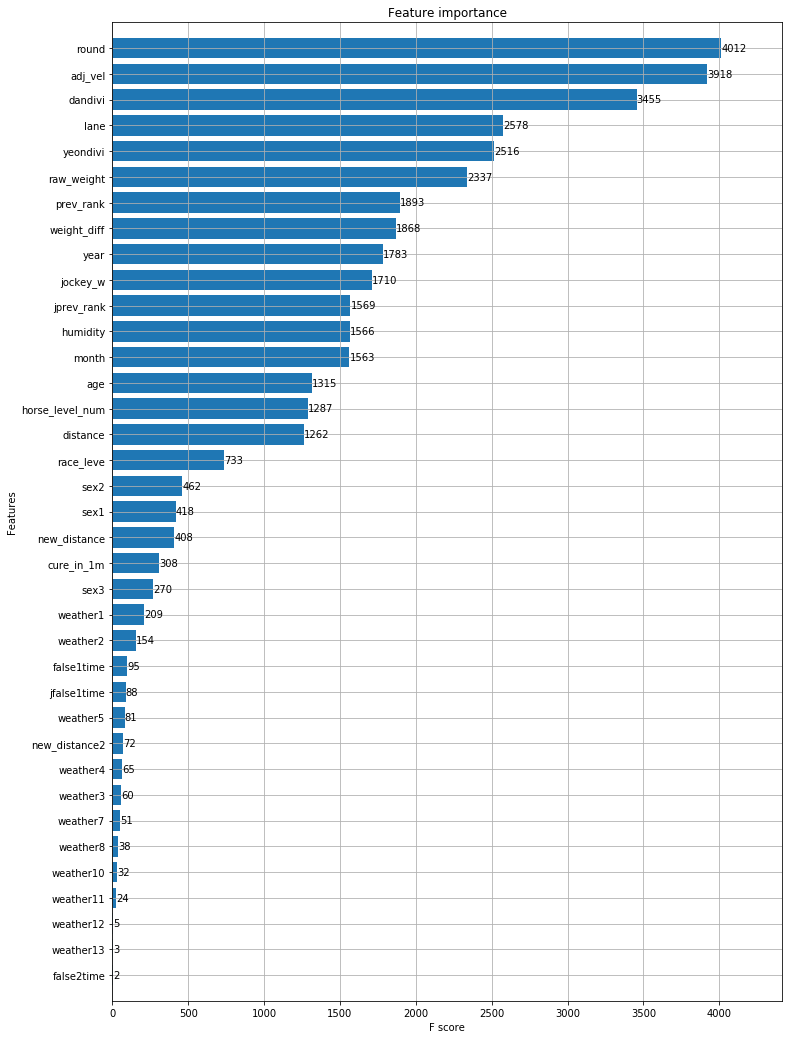

In [46]:
from matplotlib import pyplot as plt ### 이건 XGB 다 돌리고 나서 feature importance 찍는 것.
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
import category_encoders as ce

In [2]:
race_result = pd.read_csv(r'hyunse_df.csv', encoding = 'utf-8')

In [6]:
race_result.columns

Index(['date', 'round', 'code', 'url', 'name', 'rank', 'lane', 'sex', 'age',
       'jockey_w', 'rating', 'jockey', 'difference', 'weight', 'dandivi',
       'yeondivi', 's1fr', 'c1r', 'c2r', 'c3r', 'c4r', 'g1fr', 's1f', 'c1',
       'c2', 'c3', 'c4', 'g3f', 'g1f', 'record', 'cure_in_1m', 'weight_diff',
       'raw_weight', 'weight_added', 'distance', 'velocity', 'prev1_rank',
       'prev2_rank', 'prev3_rank', 'prev1_velo', 'prev2_velo', 'prev3_velo',
       'horse_level_num', 'year', 'month', 'choice', 'choice2', 'choice3',
       'danwin1yr', 'bokwin1yr', 'samwin1yr', 'jdanwin1yr', 'jbokwin1yr',
       'jsamwin1yr', 'jprev1_rank', 'jprev2_rank', 'jprev3_rank', 'race_level',
       'new_distance', 'groupid', 'avg_vel', 'adj_vel', 'prev_rank',
       'false1time', 'false2time', 'jprev_rank', 'jfalse1time', 'jfalse2time',
       'norating', 'sex1', 'sex2', 'humidity', 'weather', 'race_leve', 'sex3'],
      dtype='object')

In [5]:
race_result['sex3'] = 1 - race_result['sex1'] - race_result['sex2']

In [7]:
li = ['record', 'round', 'lane', 'sex1', 'sex2', 'sex3', 'age', 'jockey_w', 'dandivi', 'yeondivi', 'cure_in_1m', 'weight_diff', 'raw_weight',
      'distance', 'horse_level_num', 'year', 'month', 'new_distance', 'race_leve', 'new_distance', 'adj_vel', 'prev_rank', 'jprev_rank',
      'false1time', 'false2time', 'jfalse1time', 'jfalse2time', 'humidity', 'weather']
df = race_result[li].dropna()
df

,record,round,lane,sex1,sex2,sex3,age,jockey_w,dandivi,yeondivi,...,new_distance,adj_vel,prev_rank,jprev_rank,false1time,false2time,jfalse1time,jfalse2time,humidity,weather
0,111.2,10,10,1,0,0,4,54.0,1.9,1.2,...,1,1.022535,4.0,5.5,0.0,0.0,0.0,0.0,16.0,맑음
1,111.5,10,3,0,0,1,6,54.5,40.2,8.1,...,1,1.019784,3.5,7.5,0.0,0.0,0.0,0.0,16.0,맑음
2,111.7,10,11,0,1,0,3,55.5,4.7,2.0,...,0,1.017958,3.0,6.5,0.0,0.0,0.0,0.0,16.0,맑음
3,111.7,10,6,0,0,1,3,52.0,14.5,3.6,...,0,1.017958,2.5,6.5,0.0,0.0,0.0,0.0,16.0,맑음
4,112.0,10,2,0,0,1,3,52.0,13.8,3.6,...,1,1.015232,4.5,6.5,0.0,0.0,0.0,0.0,16.0,맑음
5,112.4,10,4,1,0,0,3,52.0,7.5,2.3,...,0,1.011619,4.5,7.5,0.0,0.0,0.0,0.0,16.0,맑음
6,113.0,10,12,1,0,0,5,52.5,27.8,4.2,...,1,1.006247,4.0,5.0,0.0,0.0,0.0,0.0,16.0,맑음
7,113.2,10,1,0,0,1,3,56.0,10.9,2.5,...,0,1.004469,6.5,6.5,0.0,0.0,0.0,0.0,16.0,맑음
8,113.3,10,9,0,0,1,5,53.5,22.3,3.4,...,1,1.003583,4.5,5.5,0.0,0.0,0.0,0.0,16.0,맑음
9,114.1,10,5,0,0,1,3,52.0,69.5,11.8,...,1,0.996546,8.0,5.5,0.0,0.0,0.0,0.0,16.0,맑음


In [10]:
le =  ce.OneHotEncoder(return_df=False, impute_missing=False, handle_unknown="ignore") 
weather = le.fit_transform(list(df['weather']))

In [13]:
del df['weather']

In [44]:
race_result.iloc[0,:]

date                                                   2018-10-07
round                                                          10
code                                                        39820
url             http://www.gumvit.com/statv40/result_detail.ht...
name                                                       나스카의태양
rank                                                            1
lane                                                           10
sex                                                             수
age                                                             4
jockey_w                                                       54
rating                                                         59
jockey                                                      80103
difference                                                    NaN
weight                                                    447(-7)
dandivi                                                       1.9
yeondivi  

In [43]:
df[0]

array([ 1.11200000e+02,  1.00000000e+01,  1.00000000e+01,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.00000000e+00,  5.40000000e+01,
        1.90000000e+00,  1.20000000e+00,  0.00000000e+00, -7.00000000e+00,
        4.47000000e+02,  1.70000000e+03,  3.00000000e+00,  2.01800000e+03,
        1.00000000e+01,  1.00000000e+00,  3.00000000e+00,  1.00000000e+00,
        1.02253541e+00,  4.00000000e+00,  5.50000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.60000000e+01,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [18]:
dfn = np.array(df)

In [22]:
dfn = np.append(dfn, weather, axis=1)

In [24]:
df=dfn
del dfn

In [45]:
# train-test split with cross validation
ft = ['round', 'lane', 'sex1', 'sex2', 'sex3', 'age', 'jockey_w', 'dandivi', 'yeondivi', 'cure_in_1m', 'weight_diff', 'raw_weight',
      'distance', 'horse_level_num', 'year', 'month', 'new_distance', 'race_leve', 'new_distance2', 'adj_vel', 'prev_rank', 'jprev_rank',
      'false1time', 'false2time', 'jfalse1time', 'jfalse2time', 'humidity', 'weather1', 'weather2', 'weather3', 'weather4', 'weather5', 'weather6', 'weather7', 'weather8', 'weather9', 'weather10', 'weather11', 'weather12', 'weather13']

cv = KFold(5, shuffle=True, random_state=156)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    train = df[idx_train]
    test = df[idx_test]

    # 맨 앞 칼럼이 record time(종속변수)이라서 따로 떼어줌.
    real1 = train[:,0]; real2 = test[:,0]
    
    # xgb에서 쓸 수 있도록 자료형 변경
    xgb_train = xgb.DMatrix(train[:,1:], label=real1, feature_names = ft) 
    xgb_test = xgb.DMatrix(test[:,1:], label=real2, feature_names = ft)
   

#     xgb2 = xgb.XGBClassifier(learning_rate=0.1,
#                              n_estimators=1000, 
#                              max_depth=20,
#                              min_child_weight=1,
#                              gamma=0,
#                              subsample=0.8,
#                              colsample_bytree=0.8,
#                              objective= 'reg:linear',
#                              scale_pos_weight=1,
#                              seed=27)
#     xgb2_param = xgb2.get_xgb_params()
#     # train & test
#     num_round = 200
#     bst = xgb.train(xgb2_param, xgb_train, num_round) # train
#     pred1 = bst.predict(xgb_train) # test
#     pred2 = bst.predict(xgb_test)
    
    param = {'min_child_weight':1,'max_depth':10, 'eta':0.1, 'gamma':0, 'lambda':1, 'silent':1, 'objective':'reg:linear', 'subsample':0.9, 'colsample_bytree':0.8}
    bst = xgb.train(param, xgb_train, 100) # train
    pred2 = bst.predict(xgb_test) # test
    pred1 = bst.predict(xgb_train)

    # Mean Absolute Error 출력
    print('max_depth: {0}, train_error: {1}, test_error: {2}'.format('20', abs(pred1-real1).mean(), abs(pred2-real2).mean()))
    break

max_depth: 20, train_error: 1.0614009588512268, test_error: 1.9169512144733336


In [26]:
cv = KFold(5, shuffle=True, random_state=156)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    train = df[idx_train]
    test = df[idx_test]
    

    break

In [29]:
train.shape

(43306, 41)

In [51]:
li = ['record','round', 'distance', 'humidity', 'dandivi', 'lane', 'age', 'yeondivi', 'jockey_w','cure_in_1m',  \
            'raw_weight', 'horse_level_num', 'race_leve',  'sex1', 'sex2', 'sex3', 'year', 'month', 'weather']

df = race_result[li].dropna()

le =  ce.OneHotEncoder(return_df=False, impute_missing=False, handle_unknown="ignore") 
weather = le.fit_transform(list(df['weather']))

del df['weather']

df=np.array(df)
df = np.append(df, weather, axis=1)

li.extend(['weather2', 'weather3', 'weather4', 'weather5', 'weather6', 'weather7', 'weather8', 'weather9', 'weather10', 'weather11', 'weather12', 'weather13'])

In [52]:
# train-test split with cross validation
ft = li[1:]
cv = KFold(5, shuffle=True, random_state=156)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    train = df[idx_train]
    test = df[idx_test]

    # 맨 앞 칼럼이 record time(종속변수)이라서 따로 떼어줌.
    real1 = train[:,0]; real2 = test[:,0]
    
    # xgb에서 쓸 수 있도록 자료형 변경
    xgb_train = xgb.DMatrix(train[:,1:], label=real1, feature_names = ft) 
    xgb_test = xgb.DMatrix(test[:,1:], label=real2, feature_names = ft)
   

#     xgb2 = xgb.XGBClassifier(learning_rate=0.1,
#                              n_estimators=1000, 
#                              max_depth=20,
#                              min_child_weight=1,
#                              gamma=0,
#                              subsample=0.8,
#                              colsample_bytree=0.8,
#                              objective= 'reg:linear',
#                              scale_pos_weight=1,
#                              seed=27)
#     xgb2_param = xgb2.get_xgb_params()
#     # train & test
#     num_round = 200
#     bst = xgb.train(xgb2_param, xgb_train, num_round) # train
#     pred1 = bst.predict(xgb_train) # test
#     pred2 = bst.predict(xgb_test)
    
    param = {'min_child_weight':1,'max_depth':10, 'eta':0.1, 'gamma':0, 'lambda':1, 'silent':1, 'objective':'reg:linear', 'subsample':0.9, 'colsample_bytree':0.8}
    bst = xgb.train(param, xgb_train, 100) # train
    pred2 = bst.predict(xgb_test) # test
    pred1 = bst.predict(xgb_train)

    # Mean Absolute Error 출력
    print('max_depth: {0}, train_error: {1}, test_error: {2}'.format('20', abs(pred1-real1).mean(), abs(pred2-real2).mean()))
    break

max_depth: 20, train_error: 1.4638686509728103, test_error: 2.2469899835055607
